In [5]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import duckdb as db
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)
# sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style="whitegrid")

In [2]:
df=pd.read_parquet("../data/cleaned/df_time_series.parquet")
df.head()

,Temperature,Rainfall_last_hour,Cloud_Cover,Traffic_Vol,data,Holiday,is_weekend,x0_airborne particles,x0_airborne smoke,x0_clear skies,x0_cloudy skies,x0_dense fog,x0_light fog,x0_light rain,x0_rainfall,x0_snowfall,x0_stormy weather,x0_sudden windstorm
TimeStamp,,,,,,,,,,,,,,,,,,
2011-06-11 20:00:00,288.086,0,92,2888.0,Train,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-12 18:00:00,298.043,0,0,4389.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-12 20:00:00,292.961,0,8,3102.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-12 21:00:00,292.361,0,9,3300.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-13 21:00:00,295.340,0,76,3048.0,Train,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
orig = df[df["data"]=="Train"]
submission = df[df["data"]=="Test"]

In [ ]:
orig = orig.drop(columns=["data"])

In [7]:
train = orig.iloc[:int(0.8*len(orig))]
test = orig.iloc[int(0.8*len(orig)):]

In [9]:

model = SARIMAX(
    endog=train["Traffic_Vol"], 
                  exog= train[["Temperature", "Rainfall_last_hour", "Cloud_Cover", "Holiday", "is_weekend"]],
                  order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
model = model.fit()

c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Traffic_Vol   No. Observations:                19580
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -155174.591
Date:                            Tue, 05 Nov 2024   AIC                         310369.181
Time:                                    20:46:56   BIC                         310447.992
Sample:                                         0   HQIC                        310394.994
                                          - 19580                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Temperature           12.8788      1.748      7.366      0.000       9.452      16.306
Rainfall_last_hour   -93.5329     26.626     -3.513      0.000    -145.718     -41.348
Cloud_Cover           -0.1552      0.161     -0.966      0.334      -0.470       0.160
Holiday             -441.2944     75.070     -5.878      0.000    -588.428    -294.161
is_weekend           486.8730     28.138     17.303      0.000     431.724     542.022
ar.L1                  0.7396      0.005    163.064      0.000       0.731       0.748
ma.L1                  0.4537      0.005     93.763      0.000       0.444       0.463
ar.S.L24               0.1801      0.006     31.588      0.000       0.169       0.191
ma.S.L24              -0.8857      0.003   -258.520      0.000      -0.892      -0.879
sigma2              4.718e+05   2569.110    183.655      0.000    4.67e+05    4.77e+05
===================================================================================
Ljung-Box (L1) (Q):                  69.45   Jarque-Bera (JB):             43241.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
future=model.forecast(steps=len(test), exog=test[["Temperature", "Rainfall_last_hour", "Cloud_Cover", "Holiday", "is_weekend"]])

c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [13]:
mape(test["Traffic_Vol"], future)

1.8181081706585955

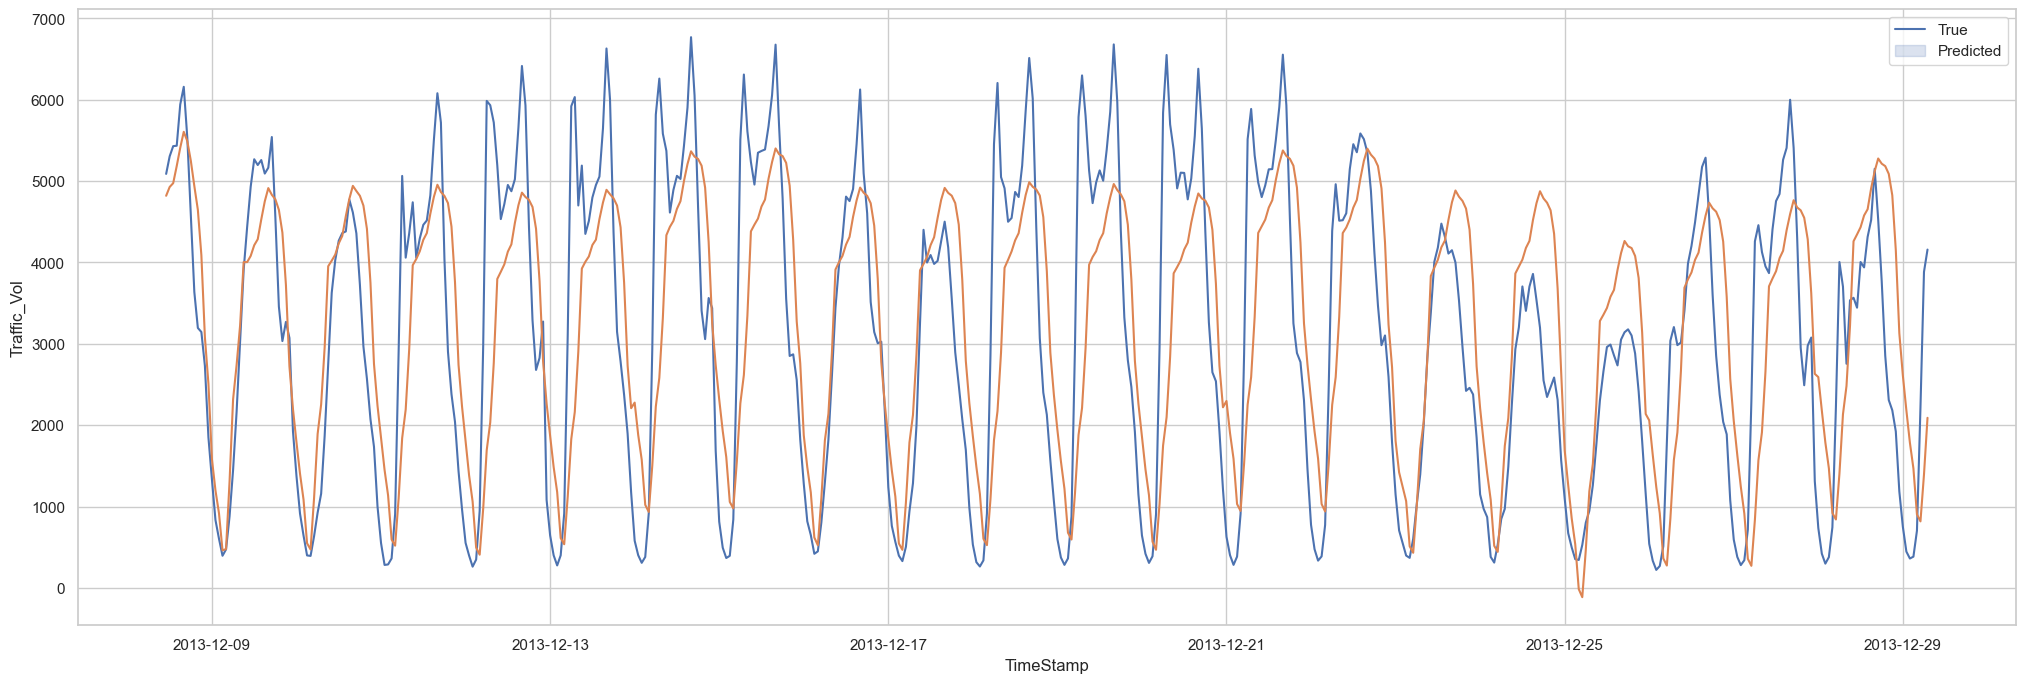

In [19]:
plt.figure(figsize=(25, 8))
sns.lineplot(data=test[:500], x=test[:500].index, y="Traffic_Vol")
sns.lineplot(data=future[:500].to_frame(name="predicted_mean"), x=test[:500].index, y="predicted_mean")
plt.legend(["True", "Predicted"])
# set xlim  to zoom in


In [ ]:
model.forecast(steps=len(submission), exog=submission[["Temperature", "Rainfall_last_hour", "Cloud_Cover", "Holiday", "is_weekend"]])